# Classifying Names with an LSTM

In this notebook I'll try to improve the name classifier we built in [Classifying with an RNN](https://nbviewer.jupyter.org/github/bobflagg/classifying-names/blob/master/Classifying-Names-RNN.ipynb) by using an [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) instead of a vanilla [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network).

To keep the presentation focused on what's new, I've put the data preprocessing code in the [names module](https://github.com/bobflagg/classifying-names/blob/master/names.py) so we can easily load it using the NamesDataset class.

In [1]:
from names import NamesDataset, predict

batch_size = 16
dataset = NamesDataset(directory='./data/names/', verbose=False)
train_loader, test_loader = dataset.build_data_loaders(batch_size)
X, y = iter(train_loader).next()
seq_len, num_chars, num_classes = dataset.seq_len, dataset.num_chars, dataset.num_classes
languages = dataset.languages
print("Names batch shape/type:", X.shape, "/", X.dtype)
print("Labels batch shape/type:", y.shape, "/", y.dtype)

Names batch shape/type: torch.Size([16, 19, 57]) / torch.float32
Labels batch shape/type: torch.Size([16]) / torch.float32


I've also put the training, evaluation and visualization code in a separate [module](https://github.com/bobflagg/classifying-names/blob/master/utils.py) to simplify experimenting with different models for classification.

In [2]:
%matplotlib inline

from util import get_accuracy, show_accuracy, show_confusion, train

## An LSTM Classifier

Again PyTorch makes this extremely easy by providing an off-the-shelf [LSTM class](https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.LSTM).

In [3]:
import torch
import torch.nn as nn

In [4]:
class NameClassifierLSTM(nn.Module):
    def __init__(self, batch_size, num_chars, n_hidden, num_classes, n_layers=1, drop_prob=0.0):
        super(NameClassifierLSTM, self).__init__()
        
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.num_chars = num_chars
        self.num_classes = num_classes
        self.n_layers = n_layers

        if n_layers > 1: dropout = drop_prob
        else: dropout = 0.0
        self.lstm = nn.LSTM(num_chars, n_hidden, n_layers, dropout=dropout)
        self.FC = nn.Linear(n_hidden, num_classes)
        self.dropout = nn.Dropout(drop_prob)
        
    def init_hidden(self):
        weight = next(self.parameters()).data
        
        if (torch.cuda.is_available()):
            hidden = (
                weight.new(self.n_layers, self.batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, self.batch_size, self.n_hidden).zero_().cuda()
            )
        else:
            hidden = (
                weight.new(self.n_layers, self.batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, self.batch_size, self.n_hidden).zero_()
            )
        
        return hidden

    def forward(self, X):
        # transforms X to dimensions: seq-len x batch-size x num-chars
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
                
        lstm_out, self.hidden = self.lstm(X, self.hidden)      
        _, out = self.hidden
        out = self.dropout(out[-1])
        out = self.FC(out)
        
        return out.view(-1, self.num_classes) # batch_size X n_output

There are two new hyper-parameters now: n_layers and drop_prob. Let's go with default values intitally.

In [5]:
model = NameClassifierLSTM(batch_size, num_chars, 128, num_classes, n_layers=2, drop_prob=0.0)
if torch.cuda.is_available(): model.cuda()
print(model)

NameClassifierLSTM(
  (lstm): LSTM(57, 128, num_layers=2)
  (FC): Linear(in_features=128, out_features=18, bias=True)
  (dropout): Dropout(p=0.0)
)


In [6]:
%%time
test_acc, train_acc = train(
    model, 
    train_loader,
    test_loader,
    batch_size, 
    seq_len, 
    num_chars, 
    num_classes, 
    epochs=16, 
    lr=0.003
)

Epoch:   1 | Loss: 111.44 | Train Accuracy: 66.85 | Test Accuracy: 74.18
Epoch:   2 | Loss: 71.32 | Train Accuracy: 77.82 | Test Accuracy: 79.91
Epoch:   3 | Loss: 56.68 | Train Accuracy: 82.17 | Test Accuracy: 80.65
Epoch:   4 | Loss: 47.26 | Train Accuracy: 84.84 | Test Accuracy: 81.05
Epoch:   5 | Loss: 39.17 | Train Accuracy: 86.91 | Test Accuracy: 80.28
Epoch:   6 | Loss: 31.03 | Train Accuracy: 89.45 | Test Accuracy: 81.48
Epoch:   7 | Loss: 25.12 | Train Accuracy: 91.13 | Test Accuracy: 81.78
Epoch:   8 | Loss: 20.52 | Train Accuracy: 92.53 | Test Accuracy: 81.44
Epoch:   9 | Loss: 18.30 | Train Accuracy: 93.49 | Test Accuracy: 81.55
Epoch:  10 | Loss: 16.47 | Train Accuracy: 93.92 | Test Accuracy: 82.24
Epoch:  11 | Loss: 14.46 | Train Accuracy: 94.50 | Test Accuracy: 82.24
Epoch:  12 | Loss: 13.42 | Train Accuracy: 95.23 | Test Accuracy: 82.16
Epoch:  13 | Loss: 13.17 | Train Accuracy: 95.20 | Test Accuracy: 81.90
Epoch:  14 | Loss: 11.92 | Train Accuracy: 95.87 | Test Accurac

This is a little better than with a simple RNN but not as much as I hoped. Let's look at the learning curves.

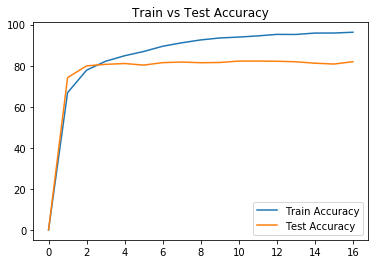

In [7]:
show_accuracy(model, test_acc, train_acc)

This clearly shows over-fitting so I'll try adding dropout to see if this can improve the results.

In [10]:
model = NameClassifierLSTM(batch_size, num_chars, 128, num_classes, n_layers=2, drop_prob=0.5)
if torch.cuda.is_available(): model.cuda()
print(model)

NameClassifierLSTM(
  (lstm): LSTM(57, 128, num_layers=2, dropout=0.5)
  (FC): Linear(in_features=128, out_features=18, bias=True)
  (dropout): Dropout(p=0.5)
)


In [11]:
%%time
test_acc, train_acc = train(
    model, 
    train_loader,
    test_loader,
    batch_size, 
    seq_len, 
    num_chars, 
    num_classes, 
    epochs=16, 
    lr=0.003
)

Epoch:   1 | Loss: 122.17 | Train Accuracy: 64.29 | Test Accuracy: 73.66
Epoch:   2 | Loss: 87.95 | Train Accuracy: 73.73 | Test Accuracy: 78.14
Epoch:   3 | Loss: 74.82 | Train Accuracy: 77.27 | Test Accuracy: 79.34
Epoch:   4 | Loss: 66.25 | Train Accuracy: 79.63 | Test Accuracy: 80.72
Epoch:   5 | Loss: 60.83 | Train Accuracy: 81.09 | Test Accuracy: 81.57
Epoch:   6 | Loss: 55.76 | Train Accuracy: 82.69 | Test Accuracy: 82.02
Epoch:   7 | Loss: 51.28 | Train Accuracy: 84.16 | Test Accuracy: 82.03
Epoch:   8 | Loss: 49.40 | Train Accuracy: 84.45 | Test Accuracy: 82.95
Epoch:   9 | Loss: 46.30 | Train Accuracy: 85.09 | Test Accuracy: 82.86
Epoch:  10 | Loss: 43.03 | Train Accuracy: 86.32 | Test Accuracy: 82.74
Epoch:  11 | Loss: 41.44 | Train Accuracy: 86.72 | Test Accuracy: 83.01
Epoch:  12 | Loss: 38.97 | Train Accuracy: 87.26 | Test Accuracy: 83.08
Epoch:  13 | Loss: 37.27 | Train Accuracy: 87.98 | Test Accuracy: 83.50
Epoch:  14 | Loss: 35.52 | Train Accuracy: 88.44 | Test Accurac

Now the accuracy is about 84% - not bad at all!  Below is the learning curves plot, which shows we've addressed over-fitting at least partially.  These results can certainly be improved upon by adjusting parameters like the number of hidden units, number of layers, learning rate, number of epochs, dropout, etc. but  optimizing hyperparameters is a challenging task, which I'll leave for a future tutorial.

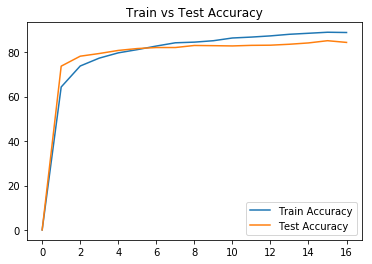

In [12]:
show_accuracy(model, test_acc, train_acc)

Here is the confusion matrix.

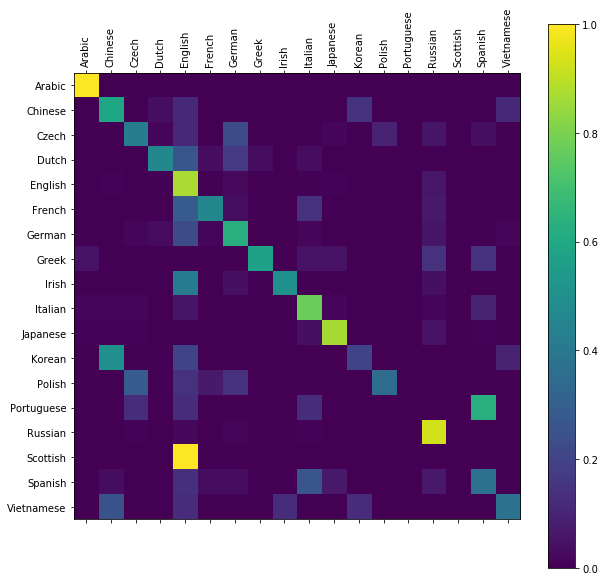

In [13]:
show_confusion(model, test_loader, languages, seq_len, num_chars)

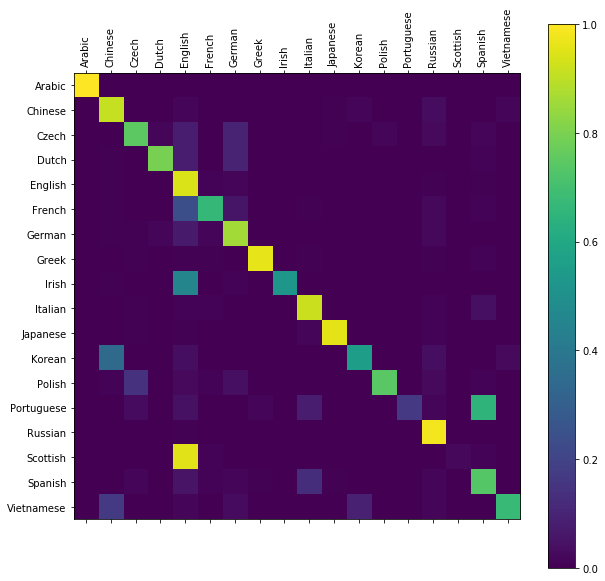

In [14]:
show_confusion(model, train_loader, languages, seq_len, num_chars)

In [15]:
for name in ['Dovesky', 'Jackson', 'Satoshi']:
    print(name, '-->>', predict(dataset, model, name))

Dovesky -->> Russian
Jackson -->> English
Satoshi -->> Japanese
